# HW 5 - Page Rank
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Fall 2018`__

In Weeks 8 and 9 you discussed key concepts related to graph based algorithms and implemented SSSP.   
In this final homework assignment you'll implement distributed PageRank using some data from Wikipedia.
By the end of this homework you should be able to:  
* ... __compare/contrast__ adjacency matrices and lists as representations of graphs for parallel computation.
* ... __explain__ the goal of the PageRank algorithm using the concept of an infinite Random Walk.
* ... __define__ a Markov chain including the conditions underwhich it will converge.
* ... __identify__ what modifications must be made to the web graph inorder to leverage Markov Chains.
* ... __implement__ distributed PageRank in Spark.

__Please refer to the `README` for homework submission instructions and additional resources.__ 

# Notebook Set-Up
Before starting your homework run the following cells to confirm your setup.

In [2]:
# imports
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
%reload_ext autoreload
%autoreload 2

In [4]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [5]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "hw5_notebook"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

In [6]:
spark

In [7]:
sc = spark.sparkContext

__`REMINDER`__: If you are running this notebook on the course docker container, you can monitor the progress of your jobs using the Spark UI at: http://localhost:4040/jobs/

# Question 1: Distributed Graph Processing
Chapter 5 from Lin & Dyer gave you a high level introduction to graph algorithms and concernts that come up when trying to perform distributed computations over them. The questions below are designed to make sure you captured the key points from this reading and your async lectures. 

### Q1 Tasks:

* __a) short response:__ Give an example of a dataset that would be appropriate to represent as a graph. What are the nodes/edges in this dataset? Is the graph you describe 'directed' or 'undirected'? What would the average "in-degree" of a node mean in the context of your example? 

* __b) short response:__ Other than their size/scale, what makes graphs uniquely challenging to work with in the map-reduce paradigm? *(__HINT__: Do not respond in terms of any specific algorithm. Think in terms of the nature of the graph datastructure itself).*

* __c) short response:__ Briefly describe Dijskra's algorithm (goal/approach). What specific design component makes this approach hard to parallelize?

* __d) short response:__ How does parallel breadth-first-search get around the problem that you identified in part `c`? At what expense?

### Q1 Student Answers:
> __a)__  
> The people on Instagram and the following statuses can be represented as a graph. In this case, each person could be a node and an edge can mean the following status between two people.  
> Since following status is directed, that is: Person A following person B does not required person B following person A. Therefore, it the graph would be directed.  
> If we define when A -> B as person A following person B, then the average "in-dgree" of a node means the average number of followers each person has in our graph. 

> __b)__  Under MapReduce, when mappers are computing, they are not aware of the work of the other mappers' and we can't control the order of the execution of map tasks. This property makes graph algorithm challenging to work with because traversing the graph and update the results from traversing the graph is by nature a sequential process. When we can't share the progress of the mappers with other mappers in the same job, this means we will have to program our algorithm is a different way.

> __c)__  
> The goal of Dijkstra's algorithm is to calculate the shortest path to any given node in the graph from a selected source node. It's approach is to start from the source node and look at all the reachable nodes from the nodes it has traversed and visit the nearest new node that has not been visited yet. This approach guarantees that whenever a node is visted, it is via the shorted path from the source node and the distance (and/or the path) is recorded.
> In order to use the above approach, there has to be shared information about which nodes have been visted and the distance to them. However, this shared information makes hard for it to be implemented in MapReduce because it involves sharing information between mappers in the same job.

> __d)__  
> The brute force search was used to get around the problem of sharing information. At every iteration, every node that could potentially produce shortest distances to other nodes in the graph is examined and the distances to its adjacent nodes calculated based on its current distance to the source node. Then in the reduce phase, the shorted distance to a node from the source is updated if a new shorter path is found.  
> 
> The drawback of the brute force search arises from the fact that we don't have the guarantee when a node is visited, we've found the shortest path. This fact not only makes detecting convergence more difficult, but also potentially increase the total number of iteration we need to run and number of nodes to examine in each iteration. In brute force search, we traverse a new node right next to our frontier, and we are not sure whether there is a shorter path that requires visiting more nodes to discover. If a shorter path is discovered later, we need to recaculated at least the distance to all its immediate nodes if not more (we need to calculate more if a shortest path to a immediate node is discovered, so on and so forth, potentially until we eventually arrive at the farthest node from the source).

# Question 2: Representing Graphs 

In class you saw examples of adjacency matrix and adjacency list representations of graphs. These data structures were probably familiar from HW3, though we hadn't before talked about them in the context of graphs. In this question we'll discuss some of the tradeoffs associated with these representations. __`NOTE:`__ We'll use the graph from Figure 5.1 in Lin & Dyer as a toy example. For convenience in the code below we'll label the nodes `A`, `B`, `C`, `D`, and `E` instead of $n_1$, $n_2$, etc but otherwise you should be able to follow along & check our answers against those in the text.


<img src="Lin-Dyer-graph-Q1.png" width="70%">

### Q2 Tasks:

* __a) short response:__ Relatively speaking, is the graph you described in Figure 5.1 in Lin & Dyer "sparse" or "dense"?  Explain how sparsity/density impacts the adjacency matrix and adjacency list representations of a graph.

* __b) short response:__ Run the provided code to create and plot our toy graph. Is this graph directed or undirected? Explain how the adjacency matrices for directed graphs will differ from those of undirected graphs.

* __c) code:__ Fill in the missing code to complete the function `get_adj_matr()`.

* __d) code:__ Fill in the missing code to complete the function `get_adj_list()`.


### Q2 Student Answers:
> __a)__
> It's more on the sparse side since there could be potentially a total of 25 edges (self-loops included, 20 when self-loops exluded), but in the graph there are only 9 edges.  
> The sparser the graph, the more wasteful from space perspective to represent the graph as an adjacency matrix since we just have a lot of zeros which is the space we can save from representing the same graph as an adjacency list.

> __b)__   
> It is directed  
> The matrices for directed graph is not symmetrical and this is a reflection of the asymmetry of the relationships between nodes. However, since in undirected graph, the relationships between any two nodes are mutual, we don't need the entire matrix to represent the graph. The space efficient way is to use only the upper triangle to represnet the graph since it would just be symmetrical along the diagonal (upper left to bottom right) if we decided to fill out the entire matrix.



In [15]:
# part a - a graph is just a list of nodes and edges (RUN THIS CELL AS IS)
TOY_GRAPH = {'nodes':['A', 'B', 'C', 'D', 'E'],
             'edges':[('A', 'B'), ('A', 'D'), ('B', 'C'), ('B', 'E'), ('C', 'D'), 
                      ('D', 'E'), ('E', 'A'),('E', 'B'), ('E', 'C')]}

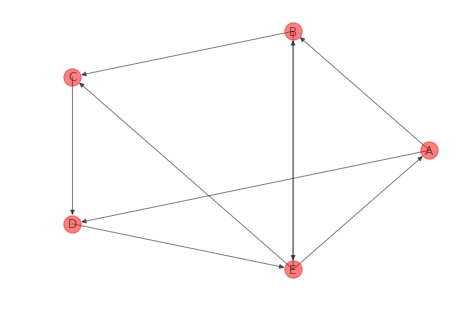

In [16]:
# part a - simple visualization of our toy graph using nx (RUN THIS CELL AS IS)
G = nx.DiGraph()
G.add_nodes_from(TOY_GRAPH['nodes'])
G.add_edges_from(TOY_GRAPH['edges'])
nx.draw(G, pos=nx.circular_layout(G), with_labels=True, alpha = 0.5)

In [17]:
# part c - adjacency matrix function
def get_adj_matr(graph):
    """
    Function to create an adjacency matrix representation of a graph.
    arg:
        graph - (dict) of 'nodes' : [], 'edges' : []
    returns:
        pd.DataFrame with entry i,j representing an edge from node i to node j
    """
    n = len(graph['nodes'])
    adj_matr = pd.DataFrame(0, columns = graph['nodes'], index = graph['nodes'])
    ############### YOUR CODE HERE ##################
    for source, dest in graph['edges']:
        adj_matr.loc[source,dest] = 1
    ############### (END) YOUR CODE #################
    return adj_matr

In [18]:
# part c - take a look (RUN THIS CELL AS IS)
TOY_ADJ_MATR = get_adj_matr(TOY_GRAPH)
print(TOY_ADJ_MATR)

   A  B  C  D  E
A  0  1  0  1  0
B  0  0  1  0  1
C  0  0  0  1  0
D  0  0  0  0  1
E  1  1  1  0  0


In [19]:
# part d - adjacency list function
def get_adj_list(graph):
    """
    Function to create an adjacency list representation of a graph.
    arg:
        graph - (dict) of 'nodes' : [], 'edges' : []
    returns:
        dictionary of the form {node : [list of edges]}
    """
    adj_list = {node: [] for node in graph['nodes']}
    ############### YOUR CODE HERE ##################
    for source, dest in graph['edges']:
        adj_list[source].append(dest)
    ############### (END) YOUR CODE #################
    return adj_list

In [20]:
# part d - take a look (RUN THIS CELL AS IS)
TOY_ADJ_LIST = get_adj_list(TOY_GRAPH)
print(TOY_ADJ_LIST)

{'A': ['B', 'D'], 'B': ['C', 'E'], 'C': ['D'], 'D': ['E'], 'E': ['A', 'B', 'C']}


# Question 3: Markov Chains and Random Walks

As you know from your readings and in class discussions, the PageRank algorithm takes advantage of the machinery of Markov Chains to compute the relative importance of a webpage using the hyperlink structure of the web (we'll refer to this as the 'web-graph'). A Markov Chain is a discrete-time stochastic process. The stochastic matrix has a principal left eigen vector corresponding to its largest eigen value which is one. A Markov chain's probability distribution over its states may be viewed as a probability vector. This steady state probability for a state is the PageRank of the corresponding webpage. In this question we'll briefly discuss a few concepts that are key to understanding the math behind PageRank. 

### Q3 Tasks:

* __a) short response:__ It is common to explain PageRank using the analogy of a web surfer who clicks on links at random ad infinitum. In the context of this hypothetical infinite random walk, what does the PageRank metric measure/represent?

* __b) short response:__ What is the "Markov Property" and what does it mean in the context of PageRank?

* __c) short response:__ A Markov chain consists of $n$ states plus an $n\times n$ transition probability matrix. In the context of PageRank & a random walk over the WebGraph what are the $n$ states? what implications does this have about the size of the transition matrix?

* __d) code + short response:__ What is a "right stochastic matrix"? Fill in the code below to compute the transition matrix for the toy graph from question 2. [__`HINT:`__ _It should be right stochastic. Using numpy this calculation can be done in one line of code._]

* __e) code + short response:__ To compute the stable state distribution (i.e. PageRank) of a "nice" graph we can apply the power iteration method - repeatedly multiplying the transition matrix by itself, until the values no longer change. Apply this strategy to your transition matrix from `part d` to find the PageRank for each of the pages in your toy graph. Your code should print the results of each iteration. How many iterations does it take to converge? Which node is most 'central' (i.e. highest ranked)? Does this match your intuition? 
    * __`NOTE 1:`__ _this is a naive approach, we'll unpack what it means to be "nice" in the next question_.
    * __`NOTE 2:`__ _no need to implement a stopping criteria, visual inspection should suffice_.

### Q3 Student Answers:
> __a)__  The probability of a web surfer visiting the a page at each moment. Or, Over a long time, the mean amount of time over the total time passed that a random web surfer spends visiting a given page.   
> _Source: Async Video: 9.5 Random Walk as a Markov Chain_

> __b)__  It means that each probability vector of PageRank only depends on the probability vector from the last state not on the states before it. Therefore, we only need the probability vector from the last state and the transition matrix to calculate the current probability vector.  
> _Source: Async Video: 9.5 Random Walk as a Markov Chain_

> __c)__  
>The interpretation of n states in the context of PageRank & a random walk over the WebGraph means the n webpages (nodes) we have in our web graph.  
>The size of the transition matrix is determined by the number of states in a way that we will have a transition matrix that has the same number of column and row as the number of states we have.  
> _Source: Async Video: 9.5 Random Walk as a Markov Chain_

> __d)__ A right stochastic matrix is a square matrix of nonnegative real numbers, with each row summing to 1.   
> _Source: Async Video: 9.5 Random Walk as a Markov Chain_

> __e)__
> It takes 49 multiplications of the transition matrix on the initial state to reach the steady state probabilities.
> Node E is the most central, having the highest score.
> It seems to match my intuition since it's the most well-connected node.

In [13]:
# part d - recall what the adjacency matrix looked like (RUN THIS CELL AS IS)
TOY_ADJ_MATR

,A,B,C,D,E
A,0,1,0,1,0
B,0,0,1,0,1
C,0,0,0,1,0
D,0,0,0,0,1
E,1,1,1,0,0


In [21]:
# part d - use TOY_ADJ_MATR to create a right stochastic transition matrix for this graph
################ YOUR CODE HERE #################
transition_matrix = TOY_ADJ_MATR.div(np.sum(TOY_ADJ_MATR, axis=1), axis=0) # replace with your code

################ (END) YOUR CODE #################
print(transition_matrix)

          A         B         C    D    E
A  0.000000  0.500000  0.000000  0.5  0.0
B  0.000000  0.000000  0.500000  0.0  0.5
C  0.000000  0.000000  0.000000  1.0  0.0
D  0.000000  0.000000  0.000000  0.0  1.0
E  0.333333  0.333333  0.333333  0.0  0.0


In [22]:
# part e - compute the steady state using the transition matrix 
def power_iteration(xInit, tMatrix, nIter, verbose = True):
    """
    Function to perform the specified number of power iteration steps to 
    compute the steady state probability distribution for the given
    transition matrix.
    
    Args:
        xInit     - (n x 1 array) representing inial state
        tMatrix  - (n x n array) transition probabilities
        nIter     - (int) number of iterations
    Returns:
        state_vector - (n x 1 array) representing probability 
                        distribution over states after nSteps.
    
    NOTE: if the 'verbose' flag is on, your function should print the step
    number and the current matrix at each iteration.
    """
    state_vector = None
    ################ YOUR CODE HERE #################
    for state_num in range(nIter+1):
        if state_num == 0:
            state_vector = xInit
        else:
            state_vector = state_vector.dot(tMatrix)
        
        print(f'State {state_num}: {state_vector}')
    
    ################ (END) YOUR CODE #################
    return state_vector

In [23]:
# part e - run 10 steps of the power_iteration (RUN THIS CELL AS IS)
xInit = np.array([1.0, 0, 0, 0, 0]) # note that this initial state will not affect the convergence states
states = power_iteration(xInit, transition_matrix, 10, verbose = True)

State 0: [1. 0. 0. 0. 0.]
State 1: [0.  0.5 0.  0.5 0. ]
State 2: [0.   0.   0.25 0.   0.75]
State 3: [0.25 0.25 0.25 0.25 0.  ]
State 4: [0.    0.125 0.125 0.375 0.375]
State 5: [0.125  0.125  0.1875 0.125  0.4375]
State 6: [0.14583333 0.20833333 0.20833333 0.25       0.1875    ]
State 7: [0.0625     0.13541667 0.16666667 0.28125    0.35416667]
State 8: [0.11805556 0.14930556 0.18576389 0.19791667 0.34895833]
State 9: [0.11631944 0.17534722 0.19097222 0.24479167 0.27256944]
State 10: [0.09085648 0.1490162  0.17853009 0.24913194 0.33246528]


__`Expected Output for part e:`__  
>Steady State Probabilities:
```
Node A: 0.10526316  
Node B: 0.15789474  
Node C: 0.18421053  
Node D: 0.23684211  
Node E: 0.31578947  
```

# Question 4: Page Rank Theory

Seems easy right? Unfortunately applying this power iteration method directly to the web-graph actually runs into a few problems. In this question we'll tease apart what we meant by a 'nice graph' in Question 3 and highlight key modifications we'll have to make to the web-graph when performing PageRank. To start, we'll look at what goes wrong when we try to repeat our strategy from question 3 on a 'not nice' graph.

__`Additional References:`__ http://pi.math.cornell.edu/~mec/Winter2009/RalucaRemus/Lecture3/lecture3.html

### Q4 Tasks:

* __a) code + short response:__ Run the provided code to create and plot our 'not nice' graph. Fill in the missing code to compute its transition matrix & run the power iteration method from question 3. What is wrong with what you see? [__`HINT:`__ _there is a visible underlying reason that it isn't converging... try adding up the probabilities in the state vector after each iteration._]

* __b) short response:__  Identify the dangling node in this 'not nice' graph and explain how this node causes the problem you described in 'a'. How could we modify the transition matrix after each iteration to prevent this problem?

* __c) short response:__ What does it mean for a graph to be irreducible? Is the webgraph naturally irreducible? Explain your reasoning briefly.

* __d) short response:__ What does it mean for a graph to be aperiodic? Is the webgraph naturally aperiodic? Explain your reasoning briefly.

* __e) short response:__ What modification to the webgraph does PageRank make in order to guarantee aperiodicity and irreducibility? Interpret this modification in terms of our random surfer analogy.


### Q4 Student Answers:
> __a)__ The sum of the probabilities is not equal to one starting the second iteration. We are losing probability as we iterate by multiplying the transition matrix.  

> __b)__ The problem in a) is caused by the dangling node, E which doesn't have any outgoing edge. It takes in probabilities but never redistributes them to other nodes. We could modify the transition matrix by having E distribute it's probability equally among all the nodes (meaning the surfer will randomly go to one of the webpages (including staying at the current page) when reaching a dead end).

> __c)__ A graph is irreducible when every node can be visited starting from any other nodes in the graph. As long as there exists one dangling node, we can't get to other nodes from the dangling node. It's not hard to imaging a dangling node in a webgraph which is equivalent to a webpage having no outgoing link. Therefore, the webgraph is not naturally irreducible.  
> _Source: Async Video: 9.5 Random Walk as a Markov Chain_

> __d)__  
> A graph is aperiodic if there is no integer k > 1 that divides the length of every cycle of the graph.  
> _Source: https://en.wikipedia.org/wiki/Aperiodic_graph_  
> The condition is satisfied when there is at least one node with a self-pointing edge in the graph. Having one page with a link to itself is probably quite common on the Internet. However, depending on the dataset with are working with, sometimes it might not be guaranteed that such self-loop exists.

> __e)__  
We will need a modification on the webgraph to make sure there is no dangling nodes and the existence of some self-loop.  
> First, we modify the transition matrix $\boldsymbol{A}$, so all the dangling nodes (originally having all zeros in their rows), to having $\frac{1}{n}, \ n\ =\ the\ number\ of\ nodes$.  
Then in PageRank, a fixed probability, $p$ between 0 and 1 is put in place and the transition matrix, $\boldsymbol{A}$ was modified to $\boldsymbol{A'}$, where $$\boldsymbol{A'} = (1-p)\cdot\boldsymbol{A} + p \cdot B, where\ B = \frac{1}{n}\cdot\begin{bmatrix}1 & 1 & \cdots & 1\\
\vdots & \vdots & \ddots & \vdots \\
1 & 1 & \cdots & 1
\end{bmatrix},\ n\ =\ the\ number\ of\ nodes$$ 
> These two modifications guarantee that none of the rows are zero (solves the dangling node issue) and also ensure aperiodicity because all the nodes now has at least a self-loop with a very small weight equal to $p\cdot\frac{1}{n}$.  
> The interpretation of the modification from a random surfer point of view is that whenever a surfer is done with a page and about to move to the next one, there is always a small probability that they will go(teleport) to any of the pages on the Web.   
> Source: http://pi.math.cornell.edu/~mec/Winter2009/RalucaRemus/Lecture3/lecture3.html


In [28]:
# part a - run this code to create a second toy graph (RUN THIS CELL AS IS)
TOY2_GRAPH = {'nodes':['A', 'B', 'C', 'D', 'E'],
              'edges':[('A', 'B'), ('A', 'C'), ('A', 'D'), ('B', 'D'), 
                       ('B', 'E'), ('C', 'A'), ('C', 'E'), ('D', 'B')]}

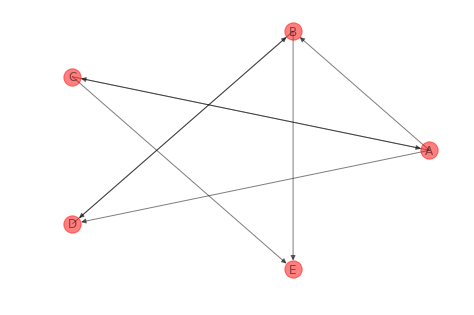

In [29]:
# part a - simple visualization of our test graph using nx (RUN THIS CELL AS IS)
G = nx.DiGraph()
G.add_nodes_from(TOY2_GRAPH['nodes'])
G.add_edges_from(TOY2_GRAPH['edges'])
nx.draw(G, pos=nx.circular_layout(G), with_labels=True, alpha = 0.5)

In [30]:
# part a - run 10 steps of the power iteration method here
# HINT: feel free to use the functions get_adj_matr() and power_iteration() you wrote above
################ YOUR CODE HERE #################

TOY2_ADJ_MATR = get_adj_matr(TOY2_GRAPH)
transition_matrix = TOY2_ADJ_MATR.div(np.sum(TOY2_ADJ_MATR, axis=1), axis=0).fillna(0)

xInit = np.array([1.0, 0, 0, 0, 0]) # note that this initial state will not affect the convergence states
states = power_iteration(xInit, transition_matrix, 10, verbose = True)

################ (END) YOUR CODE #################

State 0: [1. 0. 0. 0. 0.]
State 1: [0.         0.33333333 0.33333333 0.33333333 0.        ]
State 2: [0.16666667 0.33333333 0.         0.16666667 0.33333333]
State 3: [0.         0.22222222 0.05555556 0.22222222 0.16666667]
State 4: [0.02777778 0.22222222 0.         0.11111111 0.13888889]
State 5: [0.         0.12037037 0.00925926 0.12037037 0.11111111]
State 6: [0.00462963 0.12037037 0.         0.06018519 0.06481481]
State 7: [0.         0.0617284  0.00154321 0.0617284  0.06018519]
State 8: [0.0007716 0.0617284 0.        0.0308642 0.0316358]
State 9: [0.        0.0311214 0.0002572 0.0311214 0.0308642]
State 10: [0.0001286 0.0311214 0.        0.0155607 0.0156893]


# About the Data
The main dataset for this data consists of a subset of a 500GB dataset released by AWS in 2009. The data includes the source and metadata for all of the Wikimedia wikis. You can read more here: 
> https://aws.amazon.com/blogs/aws/new-public-data-set-wikipedia-xml-data. 

As in previous homeworks we'll be using a 2GB subset of this data, which is available to you in this dropbox folder: 
> https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAAKsjQfF9uHfv-X9mCqr9wa?dl=0. 

Use the cells below to download the wikipedia data and a test file for use in developing your PageRank implementation(note that we'll use the 'indexed out' version of the graph) and to take 
a look at the files.  

__IMPORTANT NOTE:__ For Question 8, when working with the full dataset, you will need to submit a .py script to the cluster. Please follow the instructions provided and Office Hour recordings, if you need help with this.

In [28]:
# create a data directory (RUN THIS CELL AS IS)
!mkdir data

mkdir: cannot create directory `data': File exists


In [29]:
# download the test data set (RUN THIS CELL AS IS)
# !wget -q -O data/test_graph.txt https://www.dropbox.com/sh/2c0k5adwz36lkcw/AACf_33TeM7rKfEhjEoNmMCaa/PageRank-test_indexed.txt?dl=0

In [20]:
# take a look (RUN THIS CELL AS IS)
!cat data/test_graph.txt

2	{'3': 1}
3	{'2': 2}
4	{'1': 1, '2': 1}
5	{'4': 3, '2': 1, '6': 1}
6	{'2': 1, '5': 2}
7	{'2': 1, '5': 1}
8	{'2': 1, '5': 1}
9	{'2': 1, '5': 1}
10	{'5': 1}
11	{'5': 2}

In [31]:
# download the main data set - this may take a little time (RUN THIS CELL AS IS)
# !wget -q -O data/wiki_graph.txt https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAD7I_6kQlJtDpXZPhCfVH-a/wikipedia/all-pages-indexed-out.txt?dl=0

In [32]:
# take a look (RUN THIS CELL AS IS)
!head data/wiki_graph.txt

73	{'14417532': 1}
299	{'4214575': 1}
2552	{'15043376': 1, '13430968': 1, '13451035': 1, '7263397': 1, '13001625': 1, '13443575': 1, '13451269': 1, '13432316': 1, '11623371': 1, '15028971': 1, '13425865': 1, '15042703': 1, '5051368': 1, '9854998': 2, '13442976': 1, '13315025': 1, '2992307': 1, '1054486': 1, '1322325': 1, '13450983': 1}
2570	{'983991': 1}
2616	{'9045350': 1}
2711	{'752887': 1}
2818	{'3534183': 1}
2847	{'3797918': 1}
2892	{'2893': 1}
2921	{'5158607': 1, '6007184': 1, '14773825': 1, '11777840': 2, '9285165': 1, '6420484': 1, '14670682': 1, '7316613': 1, '7125893': 1, '14965920': 1, '14229952': 1, '9447742': 2, '1425342': 1, '11390944': 2, '5141': 1, '14928135': 2, '13636570': 3, '14687433': 1, '15105458': 1, '11656072': 1, '6420027': 1, '10898196': 1, '6416278': 1, '11497740': 2}


In [33]:
# download the indexes (RUN THIS CELL AS IS)
# !wget -q -O data/indices.txt https://www.dropbox.com/sh/2c0k5adwz36lkcw/AADSYhyRXbgebRDy6ALl6O1ca/wikipedia/indices.txt?dl=0

In [34]:
# take a look (RUN THIS CELL AS IS)
!head data/indices.txt

! $var = &quot;&quot;	1	1	0
! (CONFIG.SYS directive)	2	1	1
! (album)	3	12	17
! (disambiguation)	4	1	20
! -attention-	5	1	0
! Time Zone	6	1	0
!! (chess)	7	0	1
!! (disambiguation)	8	3	0
!!! (Chk Chk Chk)	9	1	0
!!! (album)	10	5	15


In [11]:
# load the data into Spark RDDs for convenience of use later (RUN THIS CELL AS IS)
testRDD = sc.textFile('data/test_graph.txt')
indexRDD = sc.textFile('data/indices.txt')
wikiRDD = sc.textFile('data/wiki_graph.txt')

# Question 5: EDA part 1 (number of nodes)

As usual, before we dive in to the main analysis, we'll peform some exploratory data anlysis to understand our dataset. Please use the test graph that you downloaded to test all your code before running the full dataset.

### Q5 Tasks:
* __a) short response:__ In what format is the raw data? What does the first value represent? What does the second part of each line represent? [__`HINT:`__ _no need to go digging here, just visually inspect the outputs of the head commands that we ran after loading the data above._]

* __b) code + short response:__ Run the provided bash command to count the number of records in the raw dataset. Explain why this is _not_ the same as the number of total nodes in the graph.

* __c) code:__ In the space provided below write a Spark job to count the _total number_ of nodes in this graph. 

* __d) short response:__ How many dangling nodes are there in this wikipedia graph? [__`HINT:`__ _you should not need any code to answer this question._]

### Q5 Student Answers:
> __a)__  
> The first value is the node ID  
> The second value of a line is the adjacency list in the format of a dictionary with the node IDs of the connected nodes as keys and an integer as value which means how many times the same node(page) contains a link to another page (this value will be treated as the weight of an edge in the algorithm).

> __b)__  Because there are some nodes that only have in-coming links but no outgoing links; therefore, there aren't any lines for those dangling nodes.

> __d)__ There are: $15,192,277-5,781,290 = 9,410,987$ dangling nodes


In [31]:
# part b - count the number of records in the raw data (RUN THIS CELL AS IS)
!wc -l data/wiki_graph.txt

5781290 data/wiki_graph.txt


In [32]:
# part c - write your Spark job here (compute total number of nodes)
def count_nodes(dataRDD):
    """
    Spark job to count the total number of nodes.
    Returns: integer count 
    """    
    ############## YOUR CODE HERE ###############
    #helper function
    
    def extractNodes(line):
        """
        Helper function to extract target nodes from the adjacency list of a source node.
        
        Returns: 
            a list of tuples of (key, value) - key is the node ID and value is always 1
        """
        sourceNode = line.split('\t')[0]
        yield (sourceNode,1)
        
        edges = ast.literal_eval(line.split('\t')[1])
        
        for destNode in edges.keys():
            yield (destNode,1)
    
    totalCount = dataRDD.flatMap(lambda line: extractNodes(line)).reduceByKey(lambda x,y: 1).count()
    
    
    ############## (END) YOUR CODE ###############   
    return totalCount

In [33]:
# part c - run your counting job on the test file (RUN THIS CELL AS IS)
start = time.time()
tot = count_nodes(testRDD)
print(f'... completed job in {time.time() - start} seconds.')
print(f'Total Nodes: {tot}')

... completed job in 0.30724501609802246 seconds.
Total Nodes: 11


In [119]:
# part c - run your counting job on the full file (RUN THIS CELL AS IS)
start = time.time()
tot = count_nodes(wikiRDD)
print(f'... completed job in {time.time() - start} seconds.')
print(f'Total Nodes: {tot}')

... completed job in 509.4569103717804 seconds.
Total Nodes: 15192277


# Question 6 - EDA part 2 (out-degree distribution)

As you've seen in previous homeworks the computational complexity of an implementation depends not only on the number of records in the original dataset but also on the number of records we create and shuffle in our intermediate representation of the data. The number of intermediate records required to update PageRank is related to the number of edges in the graph. In this question you'll compute the average number of hyperlinks on each page in this data and visualize a distribution for these counts (the out-degree of the nodes). 

### Q6 Tasks:
* __a) code:__ In the space provided below write a Spark job to stream over the data and compute all of the following information:
 * count the out-degree of each non-dangling node and return the names of the top 10 pages with the most hyperlinks
 * find the average out-degree for all non-dangling nodes in the graph
 * take a 1000 point sample of these out-degree counts and plot a histogram of the result. 
 
 
* __b) short response:__ In the context of the PageRank algorithm, how is information about a node's out degree used?

* __c) short response:__ What does it mean if a node's out-degree is 0? In PageRank how will we handle these nodes differently than others?
 
__`NOTE:`__ Please observe scalability best practices in the design of your code & comment your work clearly. You will be graded on both the clarity and the design.

### Q6 Student Answers:

> __b)__  The out degree is used to divided the contirbution of a source node proportionally(accordiing to the weights) to the target nodes that it is pointing to. 

> __c)__  It means the node is a dangling node that doesn't have any hyperlink pointing outwards. PageRank will divide it's contribution evenly to all of the nodes including itself.

In [34]:
# part a - write your Spark job here (compute average in-degree, etc)
def count_degree(dataRDD, n):
    """
    Function to analyze out-degree of nodes in a a graph.
    Returns: 
        top  - (list of 10 tuples) nodes with most edges
        avgDegree - (float) average out-degree for non-dangling nodes
        sampledCounts - (list of integers) out-degree for n randomly sampled non-dangling nodes
    """
    # helper func
    def parse(line):
        """
        Helper function to parse the input into non-dangling nodes and their out-degrees.
        Returns: 
            a list of tuples of (key, value) - key is the node ID and value is its out-degree
        """
        node, edges = line.split('\t')
        return (node, sum(ast.literal_eval(edges).values()))
    
    ############## YOUR CODE HERE ###############

    dataRDDCached = dataRDD.map(parse).cache() #map records to nodes and its outdegrees
    
    top = dataRDDCached.takeOrdered(n, key=lambda x: -x[1]) # take the nodes with top n out-dgrees
    
    dataRDDCached = dataRDDCached.map(lambda x: x[1]).cache() #strip the node id for mean calculation and sampling
    
    avgDegree = dataRDDCached.mean() #get the mean of out-degress
    
    sampledCounts = dataRDDCached.takeSample(False, n) #sample the out-degrees
    ############## (END) YOUR CODE ###############
    
    return top, avgDegree, sampledCounts

... completed job in 0.3811185359954834 seconds
Average out-degree:  2.2
Top 10 nodes (by out-degree:)
 [('5', 5), ('6', 3), ('3', 2), ('4', 2), ('7', 2), ('8', 2), ('9', 2), ('11', 2), ('2', 1), ('10', 1)]


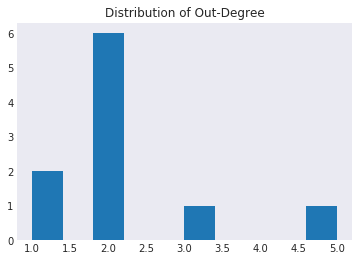

In [35]:
# part a - run your job on the test file (RUN THIS CELL AS IS)
start = time.time()
test_results = count_degree(testRDD,10)
print(f"... completed job in {time.time() - start} seconds")
print("Average out-degree: ", test_results[1])
print("Top 10 nodes (by out-degree:)\n", test_results[0])
plt.hist(test_results[2], bins=10)
plt.title("Distribution of Out-Degree")
plt.show()

... completed job in 613.04558634758 seconds
Average out-degree:  32.04181575392335
Top 10 nodes (by out-degree:)
 [('7804599', 9347), ('7858931', 8910), ('11185362', 8837), ('7705822', 8142), ('5760310', 7649), ('7865920', 7608), ('7819767', 7278), ('7883280', 7231), ('13035895', 7126), ('7880980', 6904), ('7909437', 6599), ('7810869', 6486), ('7846493', 6386), ('7841582', 6379), ('7768780', 6211), ('7820711', 6180), ('7861935', 6102), ('6075450', 6021), ('7884831', 6005), ('7777185', 5984), ('7803276', 5881), ('6074992', 5870), ('434078', 5856), ('7828359', 5853), ('7773411', 5806), ('7834538', 5788), ('10526976', 5772), ('7828391', 5606), ('1008643', 5599), ('7873008', 5595), ('7812439', 5554), ('7881486', 5552), ('7773479', 5523), ('7820535', 5520), ('7871067', 5517), ('7882833', 5504), ('7902703', 5471), ('7847103', 5449), ('5988470', 5421), ('7872661', 5419), ('7914303', 5369), ('5988469', 5363), ('7848337', 5344), ('11670785', 5341), ('7884903', 5234), ('6075178', 5217), ('60757

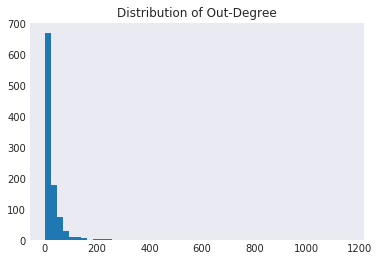

In [36]:
# part a - run your job on the full file (RUN THIS CELL AS IS)
start = time.time()
full_results = count_degree(wikiRDD,1000)
print(f"... completed job in {time.time() - start} seconds")
print("Average out-degree: ", full_results[1])
print("Top 10 nodes (by out-degree:)\n", full_results[0])
plt.hist(full_results[2], bins=50)
plt.title("Distribution of Out-Degree")
plt.show()

# Question 7 - PageRank part 1 (Initialize the Graph)

One of the challenges of performing distributed graph computation is that you must pass the entire graph structure through each iteration of your algorithm. As usual, we seek to design our computation so that as much work as possible can be done using the contents of a single record. In the case of PageRank, we'll need each record to include a node, its list of neighbors and its (current) rank. In this question you'll initialize the graph by creating a record for each dangling node and by setting the initial rank to 1/N for all nodes. 

__`NOTE:`__ Your solution should _not_ hard code $N$.

### Q7 Tasks:
* __a) short response:__ What is $N$? Use the analogy of the infinite random web-surfer to explain why we'll initialize each node's rank to $\frac{1}{N}$. (i.e. what is the probabilistic interpretation of this choice?)

* __b) short response:__ Will it be more efficient to compute $N$ before initializing records for each dangling node or after? Explain your reasoning.

* __c) code:__ Fill in the missing code below to create a Spark job that:
  * parses each input record
  * creates a new record for any dangling nodes and sets it list of neighbors to be an empty set
  * initializes a rank of 1/N for each node
  * returns a pair RDD with records in the format specified by the docstring


* __d) code:__ Run the provided code to confirm that your job in `part a` has a record for each node and that your should records match the format specified in the docstring and the count should match what you computed in question 5. [__`TIP:`__ _you might want to take a moment to write out what the expected output should be fore the test graph, this will help you know your code works as expected_]
 
__`NOTE:`__ Please observe scalability best practices in the design of your code & comment your work clearly. You will be graded on both the clarity and the design.

### Q7 Student Answers:

> __a)__  
> N is the total number of nodes in the graph  
> PageRank is basically calculating the rank for webpages. And the interpretation of rank is the probability of a web surfer visiting the a page at each moment. Therefore, the sum of all the probabilities of all pages needs to be equal to one. One simple way to initialize each node's rank is by assigning the probabilities uniformly across all nodes as $\frac{1}{N}$.

> __b)__ I think it'll be more efficient to compute N after creating new records for each dangling node. Because computing N before creating dangling nodes requires taking a pass through the edges of each node, generating a record for each target node and then comparing them with the non-dangling nodes in order to determine if we are to preserve the created records or not. This process will require data to be shuffled around which is very expensive. And we will have to do essentially the same thing when creating records for the dangling nodes. Therefore, if we compute N first then try to create the dangling node records and then initialize, we would have to go through two actions that require shuffling data around which is very expensive.
> However, if we compute N after all dangling nodes' records are created and unduplicated, we are just counting how many records we have in total which doesn't require shuffle. So I think computing N after creating new records might be more efficient.

In [36]:
# part c - job to initialize the graph (RUN THIS CELL AS IS)
def initGraph(dataRDD):
    """
    Spark job to read in the raw data and initialize an 
    adjacency list representation with a record for each
    node (including dangling nodes).
    
    Returns: 
        graphRDD -  a pair RDD of (node_id , (score, edges))
        
    NOTE: The score should be a float, but you may want to be 
    strategic about how format the edges... there are a few 
    options that can work. Make sure that whatever you choose
    is sufficient for Question 8 where you'll run PageRank.
    """
    ############## YOUR CODE HERE ###############

    # write any helper functions here
    def extractNodes(line):
        """
        Helper function to parses each input record and create a new record for any target nodes 
        and set it list of neighbors to be an empty set
        
        Returns: 
            a list of tuples of (key, value) - key is the node ID and value is either the adjacency list or a empty dictionary
        """
        sourceNode = line.split('\t')[0]
        edges = ast.literal_eval(line.split('\t')[1])

        yield (sourceNode,edges)

        for destNode in edges.keys():
            yield (destNode,{})


    def reduceRecords(rec_1, rec_2):
        """
        Helper function to reduce records by dropping the record proven to have an empty dictionary
        
        Returns: 
            a tuple of (key, value) - key is the node ID and value is either the adjacency list or a empty dictionary
        """
        if rec_1:
            return rec_1
        else:
            return rec_2
    
    # write your main Spark code here
    dataRDD = dataRDD.flatMap(lambda line: extractNodes(line)).reduceByKey(reduceRecords).cache()
    
    N = dataRDD.count() # get the number of total nodes
    
    graphRDD = dataRDD.mapValues(lambda x: (1.0/N, x)).cache() #initialize the mass of each node to 1/number of total nodes in the graph

    ############## (END) YOUR CODE ##############
    
    return graphRDD

In [37]:
# part c - run your Spark job on the test graph (RUN THIS CELL AS IS)
start = time.time()
testGraph = initGraph(testRDD).collect()
print(f'... test graph initialized in {time.time() - start} seconds.')
testGraph

... test graph initialized in 0.30297112464904785 seconds.


[('4', (0.09090909090909091, {'1': 1, '2': 1})),
 ('1', (0.09090909090909091, {})),
 ('8', (0.09090909090909091, {'2': 1, '5': 1})),
 ('9', (0.09090909090909091, {'2': 1, '5': 1})),
 ('10', (0.09090909090909091, {'5': 1})),
 ('2', (0.09090909090909091, {'3': 1})),
 ('3', (0.09090909090909091, {'2': 2})),
 ('5', (0.09090909090909091, {'4': 3, '2': 1, '6': 1})),
 ('6', (0.09090909090909091, {'2': 1, '5': 2})),
 ('7', (0.09090909090909091, {'2': 1, '5': 1})),
 ('11', (0.09090909090909091, {'5': 2}))]

In [41]:
# part c - run your code on the main graph (RUN THIS CELL AS IS)
start = time.time()
wikiGraphRDD = initGraph(wikiRDD)
print(f'... full graph initialized in {time.time() - start} seconds')

... full graph initialized in 1117.6173429489136 seconds


In [42]:
# part c - confirm record format and count (RUN THIS CELL AS IS)
start = time.time()
print(f'Total number of records: {wikiGraphRDD.count()}')
print(f'First record: {wikiGraphRDD.take(1)}')
print(f'... initialization continued: {time.time() - start} seconds')

Total number of records: 15192277
First record: [('9401906', (6.582291778908455e-08, {'13450322': 1, '10912145': 1, '6221099': 1, '5896827': 1, '12454313': 1, '6657038': 1, '3714991': 1, '11065159': 1, '1477521': 2, '11775857': 1, '14337449': 1, '6003275': 1, '11529732': 1, '9380970': 1, '6536609': 1, '9403412': 1, '1929275': 1, '9263261': 1, '13723263': 1, '4684757': 1, '3715005': 1, '13031052': 1, '4851263': 1, '11614133': 1, '14645836': 1, '4683907': 1, '12712669': 4, '2209024': 1, '12789437': 1, '4971793': 1, '4683854': 1, '4501915': 1, '8620729': 1, '5578638': 1, '9908296': 1, '4682946': 5, '4432372': 1, '8717035': 1, '12779917': 1, '14690321': 1, '12501364': 1, '12886277': 1, '9401918': 1, '2202371': 1, '5972758': 1, '15093384': 1, '3833257': 1, '4683514': 2, '3164789': 1, '10488630': 1, '2218307': 1, '6626889': 1, '14899990': 1, '9145620': 1, '12372090': 1, '6857209': 1, '6372376': 2, '4684803': 2, '4472092': 1, '6346430': 1, '4431696': 1, '13037745': 1, '14592515': 1, '2368882'

# Question 8 - PageRank part 2 (Iterate until convergence)

Finally we're ready to compute the page rank. In this last question you'll write a Spark job that iterates over the initialized graph updating each nodes score until it reaches a convergence threshold. The diagram below gives a visual overview of the process using a 5 node toy graph. Pay particular attention to what happens to the dangling mass at each iteration.

<img src='PR-illustrated.png'>



__`A Note about Notation:`__ The formula above describes how to compute the updated page rank for a node in the graph. The $P$ on the left hand side of the equation is the new score, and the $P$ on the right hand side of the equation represents the accumulated mass that was re-distributed from all of that node's in-links. Finally, $|G|$ is the number of nodes in the graph (which we've elsewhere refered to as $N$).

### Q8 Tasks:
* __a) short response:__ In terms of the infinite random walk analogy, interpret the meaning of the first term in the PageRank calculation: $\alpha * \frac{1}{|G|}$

* __b) short response:__ In the equation for the PageRank calculation above what does $m$ represent and why do we divide it by $|G|$?

* __c) short response:__ Keeping track of the total probability mass after each update is a good way to confirm that your algorithm is on track. How much should the total mass be after each iteration?

* __d) code:__ Fill in the missing code below to create a Spark job that take the initialized graph as its input then iterates over the graph and for each pass:
  * reads in each record and redistributes the node's current score to each of its neighbors
  * uses an accumulator to add up the dangling node mass and redistribute it among all the nodes. (_Don't forget to reset this accumulator after each iteration!_)
  * uses an accumulator to keep track of the total mass being redistributed.( _This is just for your own check, its not part of the PageRank calculation. Don't forget to reset this accumulator after each iteration._)
  * aggregates these partial scores for each node
  * applies telportation and damping factors as described in the formula above.
  * combine all of the above to compute the PageRank as described by the formula above.
  * 
  
   __WARNING:__ Some pages contain multiple hyperlinks to the same destination, please take this into account when redistributing the mass.

 
__`NOTE:`__ Please observe scalability best practices in the design of your code & comment your work clearly. You will be graded on both the clarity and the design.

### Q8 Student Answers:

> __a)__ The first term $\alpha * \frac{1}{|G|}$ in the interpretation of the infinite random walk means when a surfer is moving from one page to another, there is a probability, $\alpha * \frac{1}{|G|}$ that they will randomly go to one of the pages in the network(our graph). Therefore, $\alpha * \frac{1}{|G|}$ is assign to all nodes in the graph.

> __b)__ m represent the total mass from all of the dangling nodes. We divided by $|G|$ because the total mass from the dangling nodes will be assigned evenly to all of the nodes in the graph.

> __c)__ 1

In [38]:
# part d - provided FloatAccumulator class (RUN THIS CELL AS IS)

from pyspark.accumulators import AccumulatorParam

class FloatAccumulatorParam(AccumulatorParam):
    """
    Custom accumulator for use in page rank to keep track of various masses.
    
    IMPORTANT: accumulators should only be called inside actions to avoid duplication.
    We stringly recommend you use the 'foreach' action in your implementation below.
    """
    def zero(self, value):
        return value
    def addInPlace(self, val1, val2):
        return val1 + val2

In [39]:
# part d - job to run PageRank (RUN THIS CELL AS IS)
def runPageRank(graphInitRDD, alpha = 0.15, maxIter = 10, verbose = True):
    """
    Spark job to implement page rank
    Args: 
        graphInitRDD  - pair RDD of (node_id , (score, edges))
        alpha         - (float) teleportation factor
        maxIter       - (int) stopping criteria (number of iterations)
        verbose       - (bool) option to print logging info after each iteration
    Returns:
        steadyStateRDD - pair RDD of (node_id, pageRank)
    """
    # teleportation:
    a = sc.broadcast(alpha)
    
    # damping factor:
    d = sc.broadcast(1-a.value)
    
    # initialize accumulators for dangling mass & total mass
    mmAccum = sc.accumulator(0.0, FloatAccumulatorParam())
    totAccum = sc.accumulator(0.0, FloatAccumulatorParam())
    
    ############## YOUR CODE HERE ###############
    
    # write your helper functions here, 
    # please document the purpose of each clearly 
    # for reference, the master solution has 5 helper functions.
        
        
    ###################################
    # MAPPER
    ###################################   
    
    def divideMass(row):
        """
        Helper function to create a new record for any target node and calculate the mass it was given from a source node. Also pass on the graph 
        
        Returns: 
            a list of tuples of (key, value) - key is the node ID and 
                                               value is either a tuple of (original mass, adjacency list, new mass) or 
                                                               a tuple of (0, mass passing on to a target node)
        """
        sourceNode = row[0]
        mass = row[1][0]
        edges = row[1][1]
        
        if edges!={}: #if the node is not a dangling node
            totalWeight = sum(edges.values())
            for targetNode in edges.keys():
                yield (targetNode, (0, mass/totalWeight * edges[targetNode])) #put a zero in the first position to flag this record as not part of the graph
        yield (sourceNode, (mass, edges, 0.0)) # pass on the graph
    
    def updateRank(value):
        """
        Helper function to calculate the new mass of a node 
        
        Returns: (old mass, adjacency list, new mass)
        """
        oldMass = value[0]
        edges = value[1]
        P = value[2]
        
        newMass = a.value/g.value + d.value*(dm.value/g.value+P)
        return (oldMass, edges, newMass)
    
    ###################################
    # REDUCER
    ###################################
    
    def collectMass(value1, value2):
        """
        Helper function to reduce records by summing the values of mass given by source nodes
        
        Returns: 
            a list of tuples of (key, value) - key is the node ID and 
                                               value is either a tuple of (original mass, adjacency list, new mass) or 
                                                               a tuple of (0, mass passing on to a target node)
        """
        if value1[0]==0 and value2[0]==0: #when both values are not a record of the graph. simply sum the given weights
            return (0, value1[1]+value2[1])
        elif value1[0]!=0: #if the first value is a record of the graph, we sum the given weights in the last position of the tuple
            return (value1[0], value1[1], value1[2] + value2[1])
        else: #if the second value is a record of the graph, we sum the given weights in the last position of the tuple
            return (value2[0], value2[1], value2[2] + value1[1])
    
    ###################################
    # ACCUMULATOR
    ###################################
    
    def collectDanglingMass(row):
        """
        Helper function to sum the mass from all the dangling nodes
        """
        sourceNode = row[0]
        mass = row[1][0]
        edges = row[1][1]
        
        if edges == {}: #if the node is a dangling node
            mmAccum.add(mass)
    
    def collectDistributedMass(row):
        """
        Helper function to sum the mass pass on the target nodes
        """
        totAccum.add(row[1][2])
    
    def terminate(row):
        """
        Helper function to sum the differences between the old mass and the new mass of each node
        """
        if row[1][0] != row[1][2]:  
            statusAccum.add(abs(row[1][0]-row[1][2]))
        
    # write your main Spark Job here (including the for loop to iterate)
    # for reference, the master solution is 21 lines including comments & whitespace
    
    nodeCount = graphInitRDD.count() # get the count of total nodes
    g = sc.broadcast(nodeCount) #broadcast node count to executors
    
    CONVERGENCE_THRESHOLD = 0.0 #set the convergence threshold to 0 since we are just trying to run a certain number iterations.
    
    for iteration in range(maxIter):
        #reset all the accumulators
        mmAccum = sc.accumulator(0.0, FloatAccumulatorParam())
        totAccum = sc.accumulator(0.0, FloatAccumulatorParam())
        statusAccum = sc.accumulator(0.0, FloatAccumulatorParam())
        
        #get the total mass of dangling nodes and broadcast it
        graphInitRDD.foreach(collectDanglingMass)
        dm = sc.broadcast(mmAccum.value)
        
        #start the main spark job of calculating new masses while preserving the graph 
        graphInitRDD = graphInitRDD.flatMap(divideMass).reduceByKey(collectMass).mapValues(updateRank).cache()
        
        #caculating the differences of between this iteration and last
        graphInitRDD.foreach(terminate)
        
        #output results for debugging
        if verbose:
            #get the total mass distributed
            graphInitRDD.foreach(collectDistributedMass)
            print("-"*50)  
            print("iteration", iteration + 1)
            #print all the nodes
            for i in graphInitRDD.collect():
                print(i)
            #print total mass distributed and total differences between last probability vector and current one
            print("Total Mass Distributed: ", totAccum.value)
            print("Total Mass Diff:", statusAccum.value)
            print("-"*50) 
        
        #replace old mass with new mass
        graphInitRDD = graphInitRDD.mapValues(lambda value: (value[2], value[1])).cache()
        
        if statusAccum.value <= CONVERGENCE_THRESHOLD:
            break
    

 
    steadyStateRDD = graphInitRDD.mapValues(lambda value: value[0]).cache()
    ############## (END) YOUR CODE ###############
    
    return steadyStateRDD

In [40]:
# part d - run PageRank on the test graph (RUN THIS CELL AS IS)
# NOTE: while developing your code you may want turn on the verbose option
nIter = 20
testGraphRDD = initGraph(testRDD)
start = time.time()
test_results = runPageRank(testGraphRDD, alpha = 0.15, maxIter = nIter, verbose = True)
print(f'...trained {nIter} iterations in {time.time() - start} seconds.')
print(f'Top 20 ranked nodes:')
test_results.takeOrdered(20, key=lambda x: -x[1])

--------------------------------------------------
iteration 1
('1', (0.09090909090909091, {}, 0.059297520661157024))
('4', (0.09090909090909091, {'1': 1, '2': 1}, 0.06702479338842975))
('8', (0.09090909090909091, {'2': 1, '5': 1}, 0.02066115702479339))
('9', (0.09090909090909091, {'2': 1, '5': 1}, 0.02066115702479339))
('10', (0.09090909090909091, {'5': 1}, 0.02066115702479339))
('2', (0.09090909090909091, {'3': 1}, 0.29369146005509644))
('5', (0.09090909090909091, {'4': 3, '2': 1, '6': 1}, 0.3426308539944903))
('3', (0.09090909090909091, {'2': 2}, 0.09793388429752066))
('6', (0.09090909090909091, {'2': 1, '5': 2}, 0.03611570247933884))
('7', (0.09090909090909091, {'2': 1, '5': 1}, 0.02066115702479339))
('11', (0.09090909090909091, {'5': 2}, 0.02066115702479339))
Total Mass Distributed:  1.0
Total Mass Diff: 0.9230578512396694
--------------------------------------------------
--------------------------------------------------
iteration 2
('1', (0.059297520661157024, {}, 0.04670398196

[('2', 0.3620640495978871),
 ('3', 0.333992700474142),
 ('5', 0.08506399429624555),
 ('4', 0.06030963508473455),
 ('1', 0.04255740809817991),
 ('6', 0.03138662354831139),
 ('8', 0.01692511778009981),
 ('9', 0.01692511778009981),
 ('10', 0.01692511778009981),
 ('7', 0.01692511778009981),
 ('11', 0.01692511778009981)]

__`expected results for the test graph:`__
```
[(2, 0.3620640495978871),
 (3, 0.333992700474142),
 (5, 0.08506399429624555),
 (4, 0.06030963508473455),
 (1, 0.04255740809817991),
 (6, 0.03138662354831139),
 (8, 0.01692511778009981),
 (10, 0.01692511778009981),
 (7, 0.01692511778009981),
 (9, 0.01692511778009981),
 (11, 0.01692511778009981)]
```

In [ ]:
# part d - run PageRank on the full graph (RUN THIS CELL AS IS)
# NOTE: wikiGraphRDD should have been computed & cached above!
nIter = 10
start = time.time()
full_results = runPageRank(wikiGraphRDD, alpha = 0.15, maxIter = nIter, verbose = True)
print(f'...trained {nIter} iterations in {time.time() - start} seconds.')
print(f'Top 20 ranked nodes:')
full_results.takeOrdered(20, key=lambda x: - x[1])

Instead of running the cell above, submit a spark job to GCP and run PageRank algorithm there and save results.

In [3]:
!python3 submit_job_to_cluster.py \
    --project_id="adroit-chemist-229001" \
    --zone=us-central1-b \
    --cluster_name="hw5-2" \
    --gcs_bucket="w261-bucket-hou" \
    --key_file=$HOME/w261.json \
    --create_new_cluster \
    --pyspark_file=hw5_script.py > hw5_results.txt

In [8]:
#Open the result save and extract the top 20 pages having the highest ranks
#The file was renamed as hw5_results_submission.txt to avoid being over written.

f = open("hw5_results_submission.txt", "rt")
content = f.read()
f.close()

search_key = r"Top 20 ranked nodes:\n"
start_pos = content.find(search_key) + len(search_key)
end_pos = content.find(r"\n", start_pos)
topNodes = ast.literal_eval(content[start_pos:end_pos])

print('%-10s| %-15s' %('PageRank','Page ID'))
print('='*22)
for line in topNodes:
    print('%-10.6f| %-15s' %(line[1], line[0]))

PageRank  | Page ID        
0.001545  | 13455888       
0.000671  | 4695850        
0.000598  | 5051368        
0.000598  | 1184351        
0.000462  | 2437837        
0.000455  | 6076759        
0.000442  | 4196067        
0.000442  | 13425865       
0.000422  | 6172466        
0.000401  | 1384888        
0.000396  | 6113490        
0.000394  | 14112583       
0.000370  | 7902219        
0.000365  | 10390714       
0.000362  | 12836211       
0.000352  | 6237129        
0.000349  | 6416278        
0.000339  | 13432150       
0.000333  | 1516699        
0.000308  | 7990491        


In [13]:
# title\t indx\t inDeg\t outDeg
indexRDD.take(1)

['! $var = &quot;&quot;\t1\t1\t0']

In [55]:
namesKV_RDD = indexRDD.map(lambda x: (int(x.split('\t')[1]), x.split('\t')[0]))

In [56]:
namesKV_RDD.take(1)

[(1, '! $var = &quot;&quot;')]

In [10]:
# We should have saved these above, but it takes too long to run in the cloud ($$$), so for expedience:
top_20 = [(13455888, 0.0015447247129832947),
 (4695850, 0.0006710240718906518),
 (5051368, 0.0005983856809747697),
 (1184351, 0.0005982073536467391),
 (2437837, 0.0004624928928940748),
 (6076759, 0.00045509400641448284),
 (4196067, 0.0004423778888372447),
 (13425865, 0.00044155351714348035),
 (6172466, 0.0004224002001845032),
 (1384888, 0.0004012895604073632),
 (6113490, 0.00039578924771805474),
 (14112583, 0.0003943847283754762),
 (7902219, 0.000370098784735699),
 (10390714, 0.0003650264964328283),
 (12836211, 0.0003619948863114985),
 (6237129, 0.0003519555847625285),
 (6416278, 0.00034866235645266493),
 (13432150, 0.00033936510637418247),
 (1516699, 0.00033297500286244265),
 (7990491, 0.00030760906265869104)]

In [17]:
top_20_RDD = sc.parallelize(top_20)

In [18]:
top_20_RDD.take(1)

[(13455888, 0.0015447247129832947)]

# Extra Credit
(The combined extra credit points amount to approximately 5 percentage points on your final grade.)

## EC 1 - 5pts
The indexRDD we created earlier from the indices.txt file contains the titles of the pages and thier IDs.

* __a) code:__ Join this dataset with your top 20 results.
* __b) code:__ Print the results

## Join with indexRDD and print pretty

In [13]:
# part a
joinedWithNames = None
############## YOUR CODE HERE ###############
top = sc.parallelize(top_20)
joinedWithNames = indexRDD.map(lambda x: (int(x.split('\t')[1]), x.split('\t')[0])).join(top).takeOrdered(20, key=lambda x: -x[1][1])
############## END YOUR CODE ###############

In [14]:
# part b
# Feel free to modify this cell to suit your implementation, but please keep the formatting and sort order.
print("{:10s}\t| {:10s}\t| {}".format("PageRank","Page id","Title"))
print("="*100)
for r in joinedWithNames:
    print ("{:6f}\t| {:10d}\t| {}".format(r[1][1],r[0],r[1][0]))

PageRank  	| Page id   	| Title
0.001545	|   13455888	| United States
0.000671	|    4695850	| France
0.000598	|    5051368	| Germany
0.000598	|    1184351	| Animal
0.000462	|    2437837	| Canada
0.000455	|    6076759	| India
0.000442	|    4196067	| England
0.000442	|   13425865	| United Kingdom
0.000422	|    6172466	| Iran
0.000401	|    1384888	| Arthropod
0.000396	|    6113490	| Insect
0.000394	|   14112583	| World War II
0.000370	|    7902219	| List of sovereign states
0.000365	|   10390714	| Poland
0.000362	|   12836211	| The New York Times
0.000352	|    6237129	| Italy
0.000349	|    6416278	| Japan
0.000339	|   13432150	| United States Census Bureau
0.000333	|    1516699	| Australia
0.000308	|    7990491	| London


## GraphFrames
## EC 2 - 30pts
GraphFrames is a graph library which is built on top of the Spark DataFrames API.

* __a) code:__ Using the same dataset, run the graphframes implementation of pagerank.
* __b) code:__ Join the top 20 results with indices.txt and display in the same format as above.
* __c) short answer:__ Compare your results with the results from graphframes.

__NOTE:__ Feel free to create as many code cells as you need. Code should be clear and concise - do not include your scratch work. Comment your code if it's not self annotating.

In [ ]:
from graphframes import *

In [ ]:
from pyspark.sql import functions as F

In [ ]:
# load the data into Spark RDDs for convenience of use later (RUN THIS CELL AS IS)
testRDD = sc.textFile('gs://w261-bucket/wiki/test_graph.txt')
indexRDD = sc.textFile('gs://w261-bucket/wiki/indices.txt')
wikiRDD = sc.textFile('gs://w261-bucket/wiki/wiki_graph.txt')

In [ ]:
DF = wikiRDD.map(lambda x: (x.split('\t')[0], ast.literal_eval(x.split('\t')[1]))).toDF()

In [ ]:
%%time
DF.take(1)

In [ ]:
%%time
v = DF.select('_1').withColumnRenamed('_1','id').distinct()

In [ ]:
%%time
v.cache()

In [ ]:
%%time
v.show(1)

In [ ]:
import ast
def getEdges(row):
    node_id, nodes = row
    for node in nodes: 
        yield int(node_id), int(node)

In [ ]:
%%time
e = spark.createDataFrame(DF.rdd.flatMap(getEdges), ["src", "dst"])

In [ ]:
%%time
e.cache()

In [ ]:
%%time
e.show(1)

In [ ]:
%%time
# Create a GraphFrame
from graphframes import *
g = GraphFrame(v, e)

# Query: Get in-degree of each vertex.
# g.inDegrees.show()

In [ ]:
%%time
# Run PageRank algorithm, and show results.
results = g.pageRank(resetProbability=0.15, maxIter=10)

In [ ]:
%%time
top_20 = results.vertices.orderBy(F.desc("pagerank")).limit(20)

In [ ]:
%%time
top_20.show()

In [ ]:
type(top_20)

In [ ]:
top_20.take(1)

In [ ]:
%%time
namesKV_RDD = indexRDD.map(lambda x: (int(x.split('\t')[1]), x.split('\t')[0]))

In [ ]:
namesKV_DF = namesKV_RDD.toDF()

In [ ]:
namesKV_DF = namesKV_DF.withColumnRenamed('_1','id')
namesKV_DF = namesKV_DF.withColumnRenamed('_2','title')
namesKV_DF.take(1)

In [ ]:
%%time
resultsWithNames = namesKV_DF.join(top_20, namesKV_DF.id==top_20.id).orderBy(F.desc("pagerank")).collect()

In [ ]:
# TODO: use f' for string formatting
print("{:10s}\t| {:10s}\t| {}".format("PageRank","Page id","Title"))
print("="*100)
for r in resultsWithNames:
    print ("{:6f}\t| {:10s}\t| {}".format(r[3],r[2],r[1]))

Our RDD implementaion takes about 35 minutes, whereas the GraphFrame one takes around 8 minutes. GraphFrames doesn't normalize the ranks. 

### Congratulations, you have completed HW5! Please refer to the readme for submission instructions.

If you would like to provide feedback regarding this homework, please use the survey at: https://docs.google.com/forms/d/e/1FAIpQLScgIz4laP2JHChStLZx8MO0jGvrGyrOyQBnj7M4_4vcVXkB7g/viewform?usp=sf_link